# Riemannian VAE Geodesics

In [1]:
#Modules
import jax.numpy as jnp
import jax.random as jrandom
from jax import vmap, jit

import numpy as np

import haiku as hk

import torch
import torchvision.utils as vutils

from abc import ABC

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

import os

from geometry.geodesics.riemannian import JAXOptimization, ScipyOptimization, GEORCE

from load_manifold import load_manifold
from vae.model_loader import mnist_generator, svhn_generator, celeba_generator, load_model

from vae.models import mnist_encoder
from vae.models import mnist_decoder
from vae.models import mnist_vae

from vae.models import svhn_encoder
from vae.models import svhn_decoder
from vae.models import svhn_vae

from vae.models import celeba_encoder
from vae.models import celeba_decoder
from vae.models import celeba_vae

2025-03-20 00:17:00.611190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742426220.665675  187375 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742426220.683617  187375 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
plt.rcParams.update({'font.size': 12})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

In [3]:
seed = 2712
model_path = 'models/'
figure_path = '../figures/vae/'

In [4]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

## Hyper-Parameters

In [5]:
T=100
tol = 1e-3
max_iter = 100

jax_lr_rate = 0.01

### Estimation Plot 

In [6]:
def compute_estimates(M, Geodesic, z0, zT):
    
    new_method = {}
    zt, grad, idx = Geodesic(z0,zT)
    if M.f is not None:
        xt = vmap(lambda z: M.f(z))(zt)
    else:
        xt = None
    length = M.length(zt)
    
    new_method['zt'] = zt
    new_method['grad'] = grad
    new_method['idx'] = idx
    new_method['xt'] = xt
    new_method['length'] = length
    
    #zt, grad, _ = Geodesic(z0,zT, "for")
    #grad_curve = vmap(lambda z: jnp.linalg.norm(Geodesic.Denergy(z)))(zt)

    #new_method['grad_curve'] = grad_curve
    
    return new_method

In [7]:
def compute_methods(M, z0, zT, rho=.5, max_iter=max_iter,
                   tol=tol, T=T):
    
    estimates = {}
    
    Geodesic = GEORCE(M=M,
                      init_fun=None,
                      T=T,
                      tol=tol,
                      line_search_method="soft",
                      max_iter=max_iter,
                      line_search_params={'rho': rho}
                     )
    zt = jnp.vstack((z0, Geodesic.init_fun(z0,zT, T), zT))
    xt = vmap(lambda z: M.f(z))(zt)
    length = M.length(zt)
    
    new_method = {}
    new_method['zt'] = zt
    new_method['grad'] = None
    new_method['idx'] = None
    new_method['xt'] = xt
    new_method['length'] = length
    estimates['Initilization'] = new_method
    
    print("Computing GEORCE...")
    
    Geodesic = GEORCE(M=M,
                      init_fun=None,
                      T=T,
                      tol=tol,
                      line_search_method="soft",
                      max_iter=max_iter,
                      line_search_params={'rho': rho}
                     )
    estimates['GEORCE'] = compute_estimates(M, jit(Geodesic), z0, zT)
    
    print("Computing ADAM...")

    Geodesic = JAXOptimization(M = M,
                              init_fun=None,
                              lr_rate=jax_lr_rate,
                              optimizer=None,
                              T=T,
                              max_iter=max_iter,
                              tol=tol)
    estimates['ADAM'] = compute_estimates(M, jit(Geodesic), z0, zT)
    
    print("Computing BFGS...")

    Geodesic = ScipyOptimization(M = M,
                                 T=T,
                                 tol=tol,
                                 max_iter=max_iter,
                                 method="BFGS",
                                )
    estimates['BFGS'] = compute_estimates(M, Geodesic, z0, zT)
    
    return estimates

## VAE MNIST

In [8]:
latent_dim = 8

In [9]:
z0, zT, M, rho = load_manifold("mnist", dim=latent_dim)

### Loading Data

In [10]:
mnist_dataloader = mnist_generator(seed=2712,
                                   batch_size=64,
                                   split='train[:80%]')

2025-03-20 00:17:03.705044: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


### Loading Model

In [11]:
@hk.transform
def mnist_tvae(x):


    vae = mnist_vae(
                encoder=mnist_encoder(latent_dim=latent_dim),
                decoder=mnist_decoder(),
    )

    return vae(x)

@hk.transform
def mnist_tencoder(x):


    encoder = mnist_encoder(latent_dim=latent_dim)

    return encoder(x)[0]

@hk.transform
def mnist_tdecoder(x):

    decoder = mnist_decoder()

    return decoder(x)

In [12]:
mnist_state = load_model(''.join((model_path, f'mnist_{latent_dim}/')))

In [13]:
mnist_encoder_fun = lambda x: mnist_tencoder.apply(mnist_state.params, None, x.reshape(-1,
                                                                                       28,
                                                                                       28,
                                                                                       1)).reshape(-1,
                                                                                                   latent_dim).squeeze()
mnist_decoder_fun = lambda x: mnist_tdecoder.apply(mnist_state.params, None, x.reshape(-1,
                                                                                       latent_dim)).reshape(-1,
                                                                                                            28*28).squeeze()
mnist_vae_fun = lambda x: mnist_tvae.apply(mnist_state.params, mnist_state.rng_key, x)

In [14]:
mnist_data = next(mnist_dataloader).x

### Plotting Reconstruction

In [15]:
mnist_data = next(mnist_dataloader).x

In [16]:
mnist_rec = mnist_vae_fun(mnist_data)

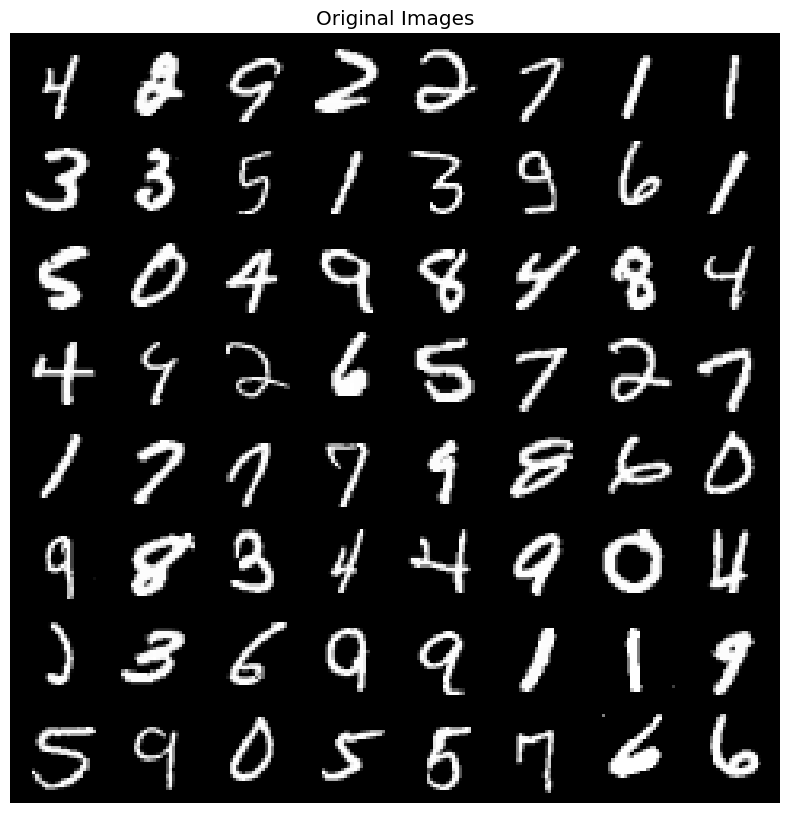

In [17]:
plot_val = torch.from_numpy(np.transpose(np.array(mnist_data), (0,3,1,2)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Original Images")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, normalize=True).cpu(),(1,2,0)))

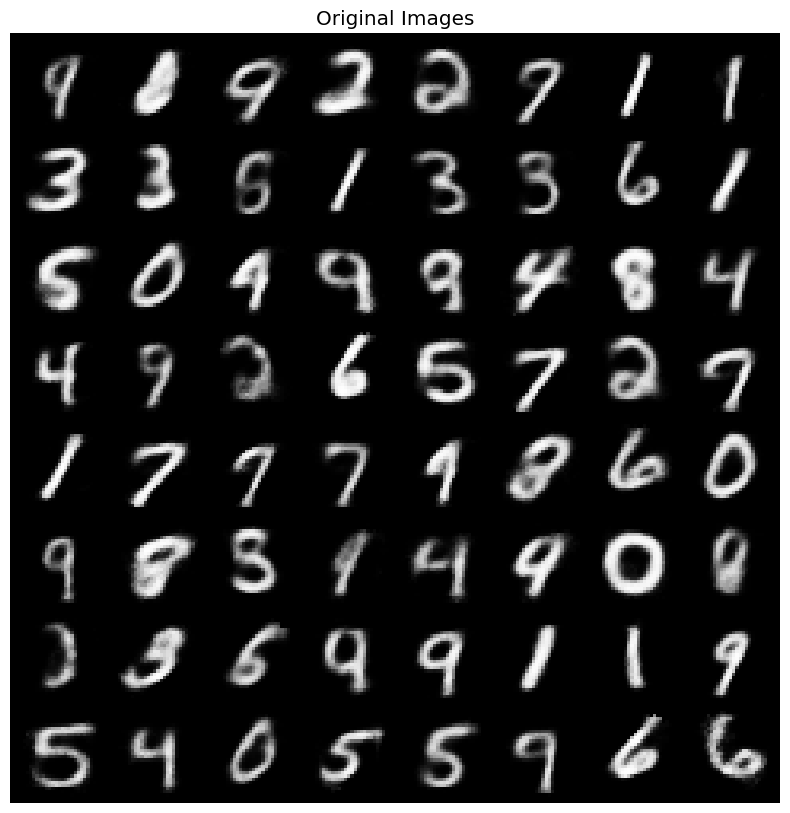

In [18]:
plot_val = torch.from_numpy(np.transpose(np.array(mnist_rec.mu_xz), (0,3,1,2)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Original Images")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, normalize=True).cpu(),(1,2,0)))

### Computing Geodesics

In [19]:
mnist_methods = compute_methods(M, z0, zT, rho=0.5)

Computing GEORCE...
Computing ADAM...
Computing BFGS...


/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/riemannian/scipy_optimization.py:122: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  res = min_fun(fun = self.energy,
/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/riemannian/scipy_optimization.py:122: RuntimeWarning: Method BFGS does not use Hessian-vector product information (hessp).
  res = min_fun(fun = self.energy,


### Plotting

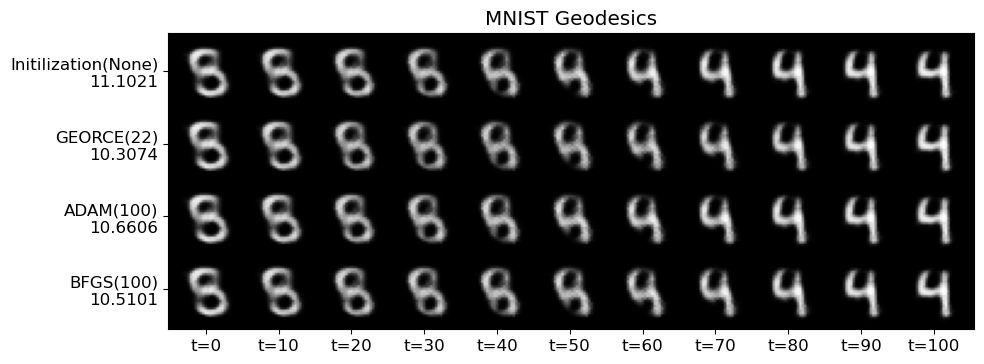

In [48]:
img_height = 28+2
plot_grid = T//10
tick_list = [img_height/2+j*img_height for j in range(len(mnist_methods))]
xt = jnp.stack([jnp.vstack((value['xt'][::plot_grid][:-1], value['xt'][-1])) for key, value in mnist_methods.items()]).reshape(-1,28,28,1)
length = [f"{key}({value['idx']})\n{value['length']:.4f}" for key, value in mnist_methods.items()]
tick_xlist = [img_height/2+j*img_height for j in range(len(mnist_methods['GEORCE']['xt'][::plot_grid]))]
grid_index = [f"t={int(plot_grid*i)}" for i in range(len(mnist_methods['GEORCE']['xt'][::plot_grid]))]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title(f"MNIST Geodesics")
plot_val = torch.from_numpy(np.transpose(np.array(xt), (0,3,1,2)))
ax.imshow(vutils.make_grid(plot_val, padding=2, normalize=True, nrow=plot_grid+1).permute(1, 2, 0))
#ax.axes.get_xaxis().set_visible(False)
ax.set_yticks(tick_list)
ax.set_yticklabels(length)
ax.set_xticks(tick_xlist)
ax.set_xticklabels(grid_index)

fig.tight_layout()

plt.show()

save_path = f'{figure_path}mnist_{latent_dim}.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')


## VAE SVHN

In [21]:
latent_dim = 32

In [22]:
z0, zT, M, rho = load_manifold("svhn", dim=latent_dim)

### Loading Data

In [23]:
svhn_dataloader = svhn_generator(data_dir="../../../Data/SVHN/",
                                 batch_size=64,
                                 seed=2712,
                                 split='train[:80%]')

3.0.0
Using ../../../Data/SVHN/svhn_cropped/3.1.0 instead.
2025-03-20 00:17:45.003713: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/73257 [00:00<?, ? examples/s]

Shuffling ../../../Data/SVHN/svhn_cropped/incomplete.AFCWIW_3.1.0/svhn_cropped-train.tfrecord*...:   0%|      …

Generating test examples...:   0%|          | 0/26032 [00:00<?, ? examples/s]

Shuffling ../../../Data/SVHN/svhn_cropped/incomplete.AFCWIW_3.1.0/svhn_cropped-test.tfrecord*...:   0%|       …

Generating extra examples...:   0%|          | 0/531131 [00:00<?, ? examples/s]

Shuffling ../../../Data/SVHN/svhn_cropped/incomplete.AFCWIW_3.1.0/svhn_cropped-extra.tfrecord*...:   0%|      …

Dataset svhn_cropped downloaded and prepared to ../../../Data/SVHN/svhn_cropped/3.1.0. Subsequent calls will reuse this data.


### Loading Model

In [24]:
@hk.transform
def svhn_tvae(x):


    vae = svhn_vae(
                encoder=svhn_encoder(latent_dim=latent_dim),
                decoder=svhn_decoder(),
    )

    return vae(x)

@hk.transform_with_state
def svhn_tencoder(x):


    encoder = svhn_encoder(latent_dim=latent_dim)

    return encoder(x)

@hk.transform_with_state
def svhn_tdecoder(x):

    decoder = svhn_decoder(latent_dim=latent_dim)

    return decoder(x)

In [25]:
svhn_state = load_model(''.join((model_path, f'svhn_{latent_dim}/')))

In [26]:
svhn_encoder_fun = lambda x: svhn_tencoder.apply(svhn_state.params, svhn_state.rng_key, x)
svhn_decoder_fun = lambda x: svhn_tdecoder.apply(svhn_state.params, svhn_state.rng_key, x)
svhn_vae_fun = lambda x: svhn_tvae.apply(svhn_state.params, svhn_state.rng_key, x)

### Plotting Reconstruction

In [27]:
svhn_data = next(svhn_dataloader).x

In [28]:
svhn_rec = svhn_vae_fun(svhn_data)

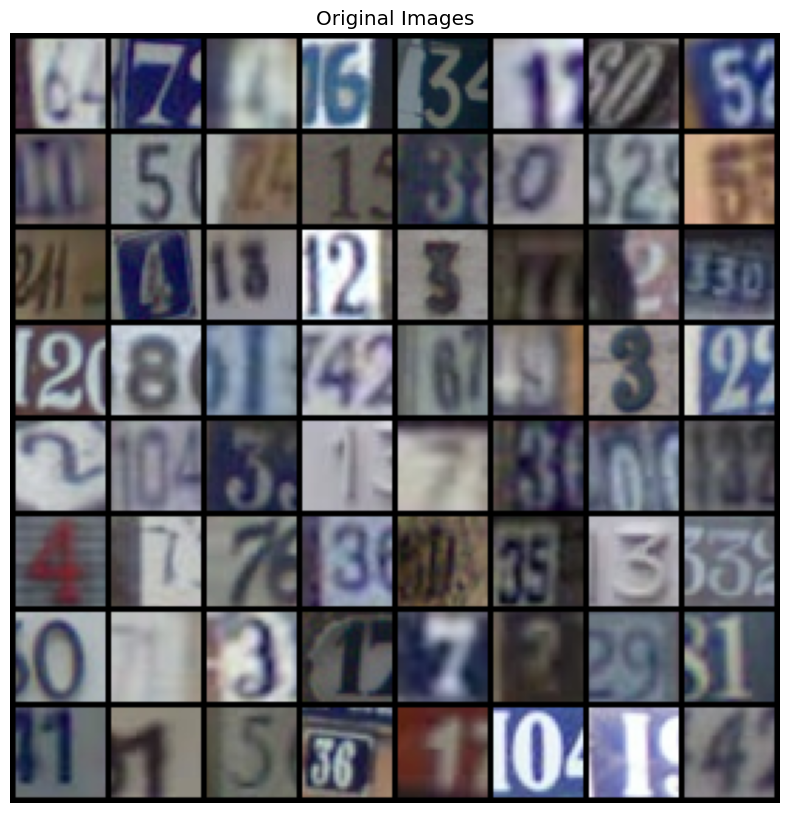

In [29]:
plot_val = torch.from_numpy(np.transpose(np.array(svhn_data), (0,3,1,2)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Original Images")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, normalize=True).cpu(),(1,2,0)))

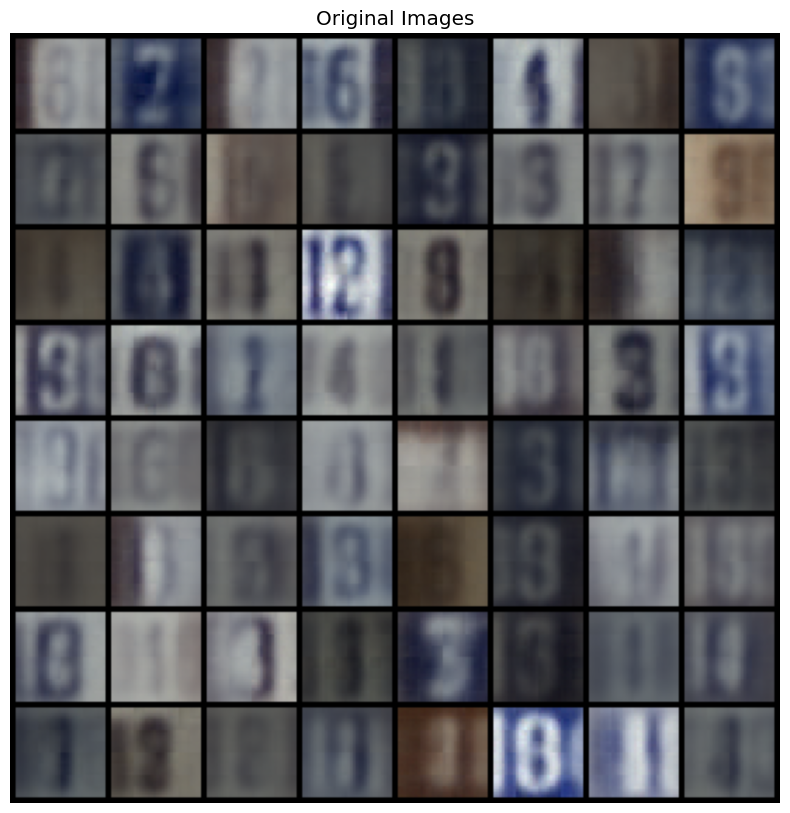

In [30]:
plot_val = torch.from_numpy(np.transpose(np.array(svhn_rec.mu_xz), (0,3,1,2)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Original Images")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, normalize=True).cpu(),(1,2,0)))

### Computing Geodesics

In [31]:
svhn_methods = compute_methods(M, z0, zT, rho=0.5)

Computing GEORCE...
Computing ADAM...
Computing BFGS...


/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/riemannian/scipy_optimization.py:122: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  res = min_fun(fun = self.energy,
/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/riemannian/scipy_optimization.py:122: RuntimeWarning: Method BFGS does not use Hessian-vector product information (hessp).
  res = min_fun(fun = self.energy,


### Plotting

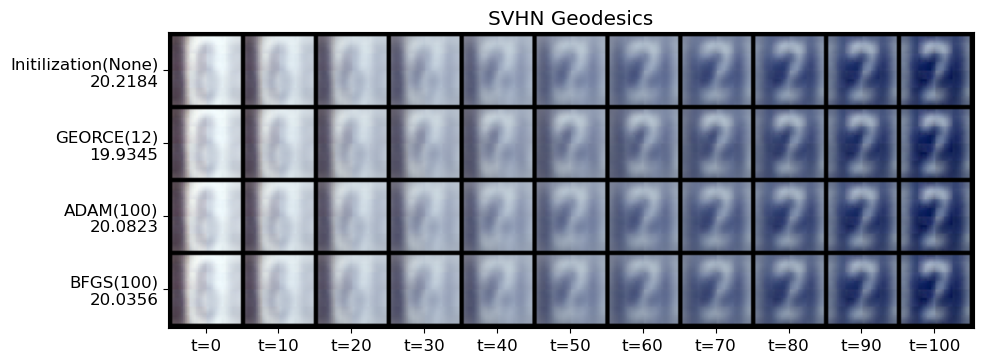

In [47]:
img_height = 32+2
plot_grid = T//10
tick_list = [img_height/2+j*img_height for j in range(len(svhn_methods))]
xt = jnp.stack([jnp.vstack((value['xt'][::plot_grid][:-1], value['xt'][-1])) for key, value in svhn_methods.items()]).reshape(-1,32,32,3)
length = [f"{key}({value['idx']})\n{value['length']:.4f}" for key, value in svhn_methods.items()]
tick_xlist = [img_height/2+j*img_height for j in range(len(svhn_methods['GEORCE']['xt'][::plot_grid]))]
grid_index = [f"t={int(plot_grid*i)}" for i in range(len(svhn_methods['GEORCE']['xt'][::plot_grid]))]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title(f"SVHN Geodesics")
plot_val = torch.from_numpy(np.transpose(np.array(xt), (0,3,1,2)))
ax.imshow(vutils.make_grid(plot_val, padding=2, normalize=True, nrow=plot_grid+1).permute(1, 2, 0))
#ax.axes.get_xaxis().set_visible(False)
ax.set_yticks(tick_list)
ax.set_yticklabels(length)
ax.set_xticks(tick_xlist)
ax.set_xticklabels(grid_index)

fig.tight_layout()

plt.show()

save_path = f'{figure_path}svhn_{latent_dim}.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')


## VAE CelebA

In [33]:
latent_dim = 32

In [34]:
z0, zT, M, rho = load_manifold("celeba", dim=latent_dim)

### Loading Data

In [35]:
celeba_dataloader = celeba_generator(data_dir="../../../Data/CelebA/",
                                     batch_size=64,
                                     seed=2712, 
                                     split=0.8)

### Loading Model

In [36]:
@hk.transform
def celeba_tvae(x):


    vae = celeba_vae(
                encoder=celeba_encoder(latent_dim=latent_dim),
                decoder=celeba_decoder(),
    )

    return vae(x)

@hk.transform
def celeba_tencoder(x):


    encoder = celeba_encoder(latent_dim=latent_dim)

    return encoder(x)

@hk.transform
def celeba_tdecoder(x):

    decoder = celeba_decoder(latent_dim=latent_dim)

    return decoder(x)

In [37]:
celeba_state = load_model(''.join((model_path, f'celeba_{latent_dim}/')))

In [38]:
celeba_encoder_fun = lambda x: celeba_tencoder.apply(celeba_state.params, celeba_state.rng_key, x)
celeba_decoder_fun = lambda x: celeba_tdecoder.apply(celeba_state.params, celeba_state.rng_key, x)
celeba_vae_fun = lambda x: celeba_tvae.apply(celeba_state.params, celeba_state.rng_key, x)

### Plotting Reconstruction

In [39]:
celeba_data = next(celeba_dataloader).x

In [40]:
celeba_rec = celeba_vae_fun(celeba_data)

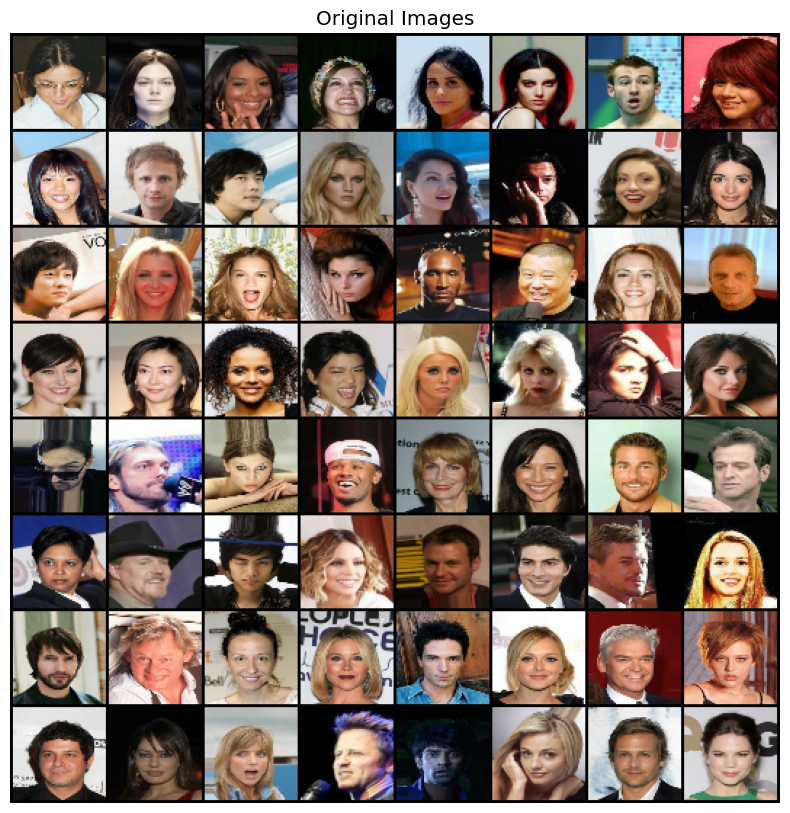

In [41]:
plot_val = torch.from_numpy(np.transpose(np.array(celeba_data), (0,3,1,2)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Original Images")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, normalize=True).cpu(),(1,2,0)))

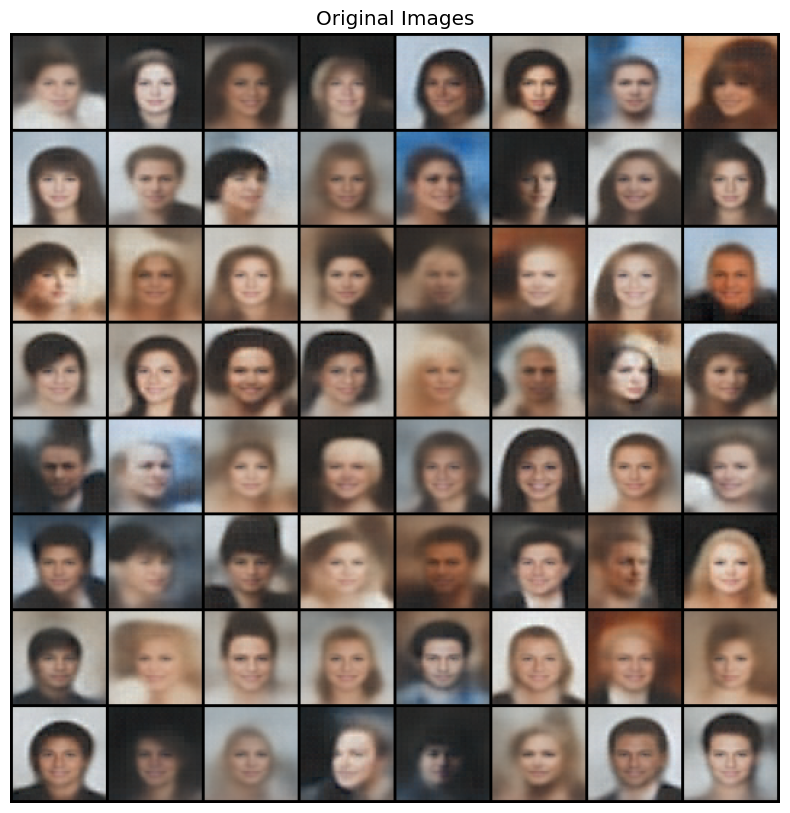

In [42]:
plot_val = torch.from_numpy(np.transpose(np.array(celeba_rec.mu_xz), (0,3,1,2)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Original Images")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, normalize=True).cpu(),(1,2,0)))

### Computing Geodesics

In [43]:
celeba_methods = compute_methods(M, z0, zT, rho=0.5)

Computing GEORCE...
Computing ADAM...
Computing BFGS...


/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/riemannian/scipy_optimization.py:122: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  res = min_fun(fun = self.energy,
/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/riemannian/scipy_optimization.py:122: RuntimeWarning: Method BFGS does not use Hessian-vector product information (hessp).
  res = min_fun(fun = self.energy,


### Plotting

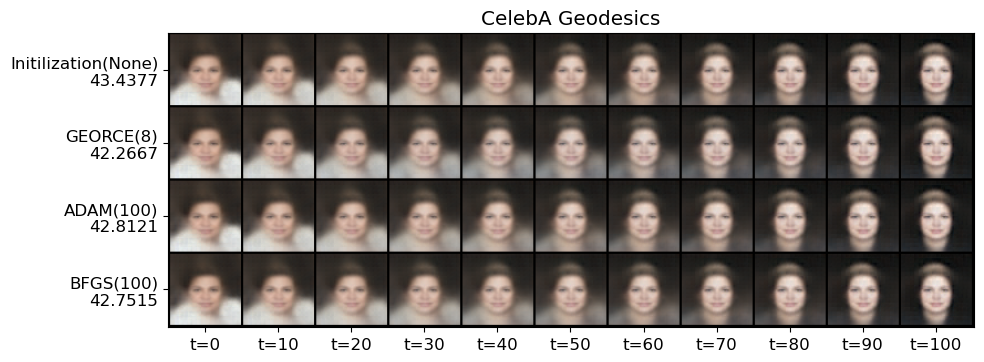

In [45]:
img_height = 64+2
plot_grid = T//10
tick_list = [img_height/2+j*img_height for j in range(len(celeba_methods))]
xt = jnp.stack([jnp.vstack((value['xt'][::plot_grid][:-1], value['xt'][-1])) for key, value in celeba_methods.items()]).reshape(-1,64,64,3)
length = [f"{key}({value['idx']})\n{value['length']:.4f}" for key, value in celeba_methods.items()]
tick_xlist = [img_height/2+j*img_height for j in range(len(celeba_methods['GEORCE']['xt'][::plot_grid]))]
grid_index = [f"t={int(plot_grid*i)}" for i in range(len(celeba_methods['GEORCE']['xt'][::plot_grid]))]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title(f"CelebA Geodesics")
plot_val = torch.from_numpy(np.transpose(np.array(xt), (0,3,1,2)))
ax.imshow(vutils.make_grid(plot_val, padding=2, normalize=True, nrow=plot_grid+1).permute(1, 2, 0))
#ax.axes.get_xaxis().set_visible(False)
ax.set_yticks(tick_list)
ax.set_yticklabels(length)
ax.set_xticks(tick_xlist)
ax.set_xticklabels(grid_index)

fig.tight_layout()

plt.show()

save_path = f'{figure_path}celeba_{latent_dim}.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')
